# Image Mask Segmentation
Task is to predict the boundaries(mask) around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 500 images with around 1100 faces manually tagged via bounding box.

### Mount Google drive to use google colab
-  recommended using Google Colab as to reduce face memory issues and longer runtimes 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/My Drive/data')
proj_path='/content/drive/Mr Drive/data/images.npy'

In [ ]:
ls

images.npy


### Load the "images.npy" file
- This file contains images with details of bounding boxes

In [ ]:
import numpy as np
data = np.load('images.npy',allow_pickle=True)

### Checking the data from the loaded "images.npy" file


In [ ]:
print(data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### Set image dimensions
- Initialize image height, image width with value to 224 as our model takes the input image of 224 size 

In [ ]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

### Creating features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X_train" array
- Masks will be stored in "masks" array

In [ ]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), 28, 28))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * 28)
        x2 = int(i["points"][1]['x'] * 28)
        y1 = int(i["points"][0]['y'] * 28)
        y2 = int(i["points"][1]['y'] * 28)
        masks[index][y1:y2, x1:x2] = 1

### Lets see  the shape of X_train and mask array

In [ ]:
X_train.shape

(409, 224, 224, 3)

In [ ]:
masks.shape

(409, 28, 28)

###  The sample image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [[-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  [-0.98431373 -0.98431373 -0.98431373]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-0.96862745 -0.96862745 -0.96862745]
  [-0.96078432 -0.96078432 -0.96078432]
  [-0.96078432 -0.96078432 -0.96078432]]

 [

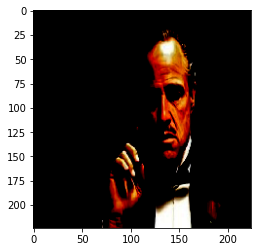

In [ ]:
from matplotlib import pyplot
n = 10
print(X_train[n])
pyplot.imshow(X_train[n])
pyplot.show()

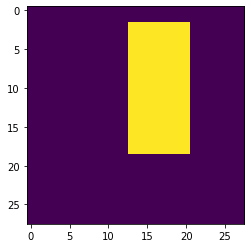

In [ ]:
pyplot.imshow(masks[n])

##  The Model ( the brain of the project )
- Used MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- And UNET architecture layers
  - This is the trickiest part of the project as we need to alter some layers of MobileNet to habituate our aim.

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model


def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT,IMAGE_WIDTH,3),include_top=False,alpha=1.0,weights='imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    lay_group1= model.get_layer("conv_pw_5_relu").output
    lay_group2= model.get_layer("conv_pw_11_relu").output
    lay_group3= model.get_layer("conv_pw_13_relu").output

    x= Concatenate()([UpSampling2D()(lay_group3),lay_group2])
    x= Concatenate() ([UpSampling2D()(x),lay_group1])
    x= Conv2D(1,kernel_size=1,activation='sigmoid')(x)
    x= Reshape((28,28))(x)

    return Model(inputs=model.input,outputs=x)

### Calling the create_model function

In [ ]:
# if given trainable=False as argument to freeze lower layers for fast training, the accuracy will be low.
model = create_model()#(False)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
______________________________________________________________________________________________

### Defining dice coefficient function
-  a function to calculate dice coefficient to check the accuracy of the model


In [ ]:
import tensorflow as tf
def dice_coefficient(y_true, y_pred):
    numr = 2 * tf.reduce_sum(y_true*y_pred)
    denom = tf.reduce_sum(y_pred + y_true) 
    return numr/(denom + tf.keras.backend.epsilon())

### Defining loss

In [ ]:
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

### Compiling the model
- Compiling the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [ ]:
model.compile(loss= loss ,optimizer = 'Adam' ,metrics=[dice_coefficient])

### Defining checkpoint and earlystopping

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

### Fit the model
- Fitting the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: checkpoint, reduce_lr, stop

In [ ]:
model.fit(x=X_train,y=masks, epochs=10,batch_size=1,callbacks=[checkpoint,reduce_lr,stop],verbose=1)

Epoch 1/10
409/409 [==============================] - ETA: 0s - loss: 1.1803 - dice_coefficient: 0.5135
Epoch 00001: loss improved from inf to 1.18026, saving model to model-1.18.h5
409/409 [==============================] - 6s 14ms/step - loss: 1.1803 - dice_coefficient: 0.5135 - lr: 0.0010
Epoch 2/10
408/409 [============================>.] - ETA: 0s - loss: 0.8118 - dice_coefficient: 0.6188
Epoch 00002: loss improved from 1.18026 to 0.81223, saving model to model-0.81.h5
409/409 [==============================] - 6s 14ms/step - loss: 0.8122 - dice_coefficient: 0.6185 - lr: 0.0010
Epoch 3/10
409/409 [==============================] - ETA: 0s - loss: 0.6926 - dice_coefficient: 0.6574
Epoch 00003: loss improved from 0.81223 to 0.69257, saving model to model-0.69.h5
409/409 [==============================] - 6s 14ms/step - loss: 0.6926 - dice_coefficient: 0.6574 - lr: 0.0010
Epoch 4/10
408/409 [============================>.] - ETA: 0s - loss: 0.6513 - dice_coefficient: 0.6755
Epoch 000

### Lets see how our model predicted mask for a sample image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


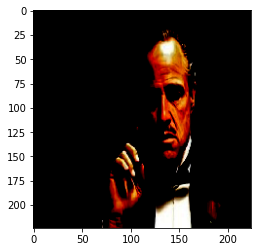

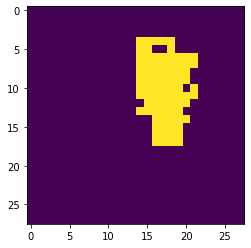

In [ ]:
n = 10
sample_image = X_train[n]
pyplot.imshow(sample_image)
pyplot.show()
sample_image=cv2.resize(sample_image,(IMAGE_WIDTH,IMAGE_HEIGHT))
pyplot.imshow(model.predict(x=np.array([sample_image]))[0]>0.5)

### Imposing the mask on the image.

In [ ]:
def impose_mask(n):
  sample_image = X_train[n]
  sample_image = cv2.resize(sample_image, (IMAGE_WIDTH, IMAGE_HEIGHT))
  pyplot.imshow(sample_image)
  pyplot.show()
  sample_image=cv2.resize(sample_image,(IMAGE_WIDTH,IMAGE_HEIGHT))
  pred_mask=cv2.resize(1.0*(model.predict(x=np.array([sample_image]))[0]>0.5),(IMAGE_WIDTH,IMAGE_HEIGHT))

  img=sample_image
  img[:,:,0]=pred_mask*img[:,:,0]
  img[:,:,1]=pred_mask*img[:,:,1]
  img[:,:,2]=pred_mask*img[:,:,2]
  pyplot.imshow(img)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


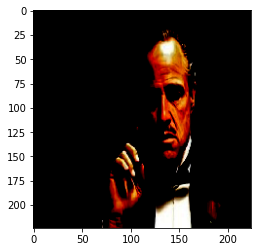

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


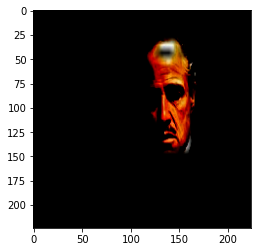

In [ ]:
impose_mask(10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


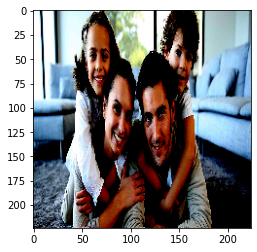

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


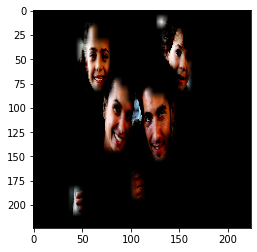

In [ ]:
impose_mask(13)